In [152]:
%matplotlib inline

from copy import deepcopy
from collections import OrderedDict
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import convolve2d 
from scipy.ndimage import imread
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Arc

def create_scale_space(image, sigma, s, num_octaves):
    space = []
    for _ in range(num_octaves):
        images = OrderedDict()
        images[0.] = image
        for i in range(s + 2):
            scale = np.power(np.power(2., 1. / s), i) * sigma
            images[scale] = (gaussian_filter(image, scale))
        image = images[list(images.keys())[-2]][::2,::2]
        space.append(images)
    return space            

def apply_dog(scale_space):
    space_of_dog = []
    for octave in scale_space:
        images = OrderedDict()
        prev = ()
        for scale, image in octave.items():
            if prev:
                images[prev[0]] = image - prev[1]
            prev = (scale, image)
        space_of_dog.append(images)
        prev = ()
    return space_of_dog

def iter_over_space(space):
    for o, octave in enumerate(space):
        for scale, image in octave.items():
            yield o, scale, np.copy(image)

def acquire_local_extrema(space):
    def is_extremum(images_with_scale, i, r, c):
        _, prev_image = images_with_scale[i - 1]
        _, current_image = images_with_scale[i]
        _, next_image = images_with_scale[i + 1]
        values = np.array([prev_image[r:r+3, c:c+3], 
                           current_image[r:r+3, c:c+3], 
                           next_image[r:r+3, c:c+3]]).flatten()
        return np.argmax(values) == 13
        
    extrema = []
    for octave in space:
        extrema_in_octave = OrderedDict()
        images_with_scale = list(octave.items())
        for i in range(1, len(images_with_scale) - 1):
            scale, image = images_with_scale[i]
            extrema_in_octave[scale] = []
            for r in range(1, image.shape[0] - 1):
                for c in range(1, image.shape[1] - 1):
                    if is_extremum(images_with_scale, i, r, c):
                        extrema_in_octave[scale].append((r, c))
        extrema.append(extrema_in_octave)
    return extrema

def draw_local_extrema(space, local_extrema, figsize=(5, 5), dpi=240):
    rows = len(space)
    cols = len(space[0])
    fig, axes = plt.subplots(rows, cols, figsize=figsize, dpi=dpi)
    for i, (o, scale, image) in enumerate(iter_over_space(space)):
        axes[o, i % cols].imshow(image, cmap='gray')
        axes[o, i % cols].axis('off')
        
        try:
            for point in local_extrema[o][scale]:
                axes[o, i % cols].add_patch(Circle(point, 2))
        except KeyError:
            pass

def eliminate_edge_responses(dog_space, local_extrema, r):
    local_extrema = deepcopy(local_extrema)
    for o in range(len(local_extrema)):
        for scale in local_extrema[o]:
            image = dog_space[o][scale]
            dr_image = np.diff(image, axis=0)
            dc_image = np.diff(image, axis=1)
            drdr_image = np.diff(dr_image, axis=0)
            drdc_image = np.diff(dr_image, axis=1)
            dcdc_image = np.diff(dc_image, axis=1)
            for point in local_extrema[o][scale]:
                r, c = point
                if r >= image.shape[0] - 2 or c >= image.shape[1] - 2:
                    del point
                    continue
                ddD = np.array([[drdr_image[r, c], drdc_image[r, c]], 
                                [drdc_image[r, c], dcdc_image[r, c]]])
                if np.power(np.trace(ddD), 2) / np.linalg.det(ddD) > np.power((r + 1), 2) / r:
                    del point
    return local_extrema

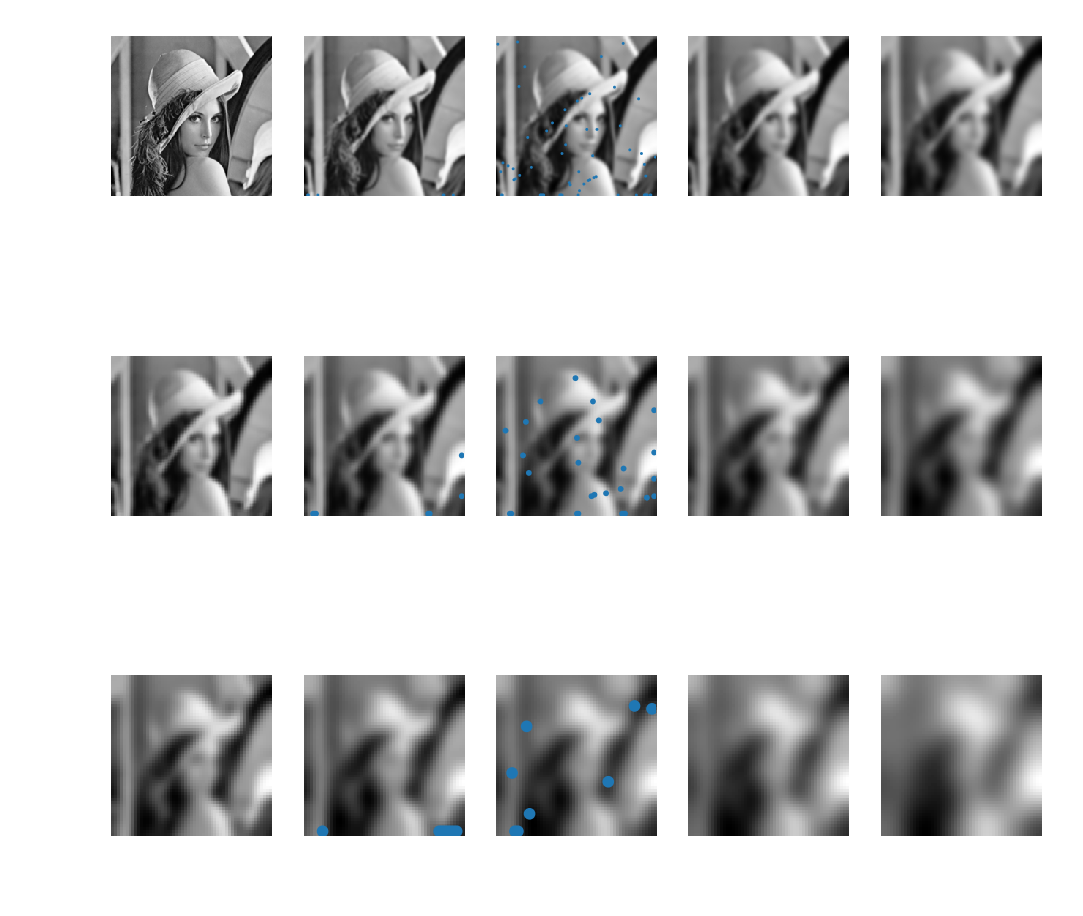

In [153]:
image = gaussian_filter(imread('../data/lenna.png', flatten=True) / 255., 0.5)
scale_space = create_scale_space(image, 1.6, 2, 3)
dog_space = apply_dog(scale_space)
local_extrema = acquire_local_extrema(dog_space)
local_extrema = eliminate_edge_responses(dog_space, local_extrema, 10)
draw_local_extrema(scale_space, local_extrema)

In [154]:
def gradient(image):
    diff_filter = np.array([[-1, 0, 1],])
    grads_row = convolve2d(image, diff_filter, boundary='symm', mode='same')
    grads_col = convolve2d(image, diff_filter.T, boundary='symm', mode='same')
    return grads_row, grads_col

def orientations(grads_row, grads_col):
    thetas = np.nan_to_num(np.arctan2(grads_row, grads_col)) * 180.0 / np.pi
    thetas[thetas < 0] += 360.0
    return thetas

In [155]:
def apply_gradient(scale_space):
    gradients = []
    for octave in scale_space:
        gradients_in_octave = {}
        for scale, image in octave.items():
            grads_row, grads_col = gradient(image)
            gradients_in_octave[scale] = {'grads': [grads_row, grads_col],
                                          'magnitudes': np.sqrt(np.power(grads_row, 2) + np.power(grads_col, 2)),
                                          'orientations': orientations(grads_row, grads_col)}
        gradients.append(gradients_in_octave)
    return gradients

In [156]:
gradients = apply_gradient(scale_space)

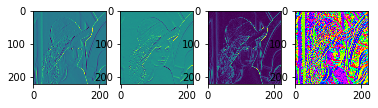

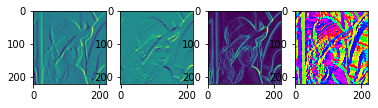

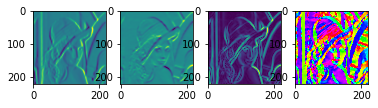

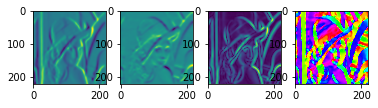

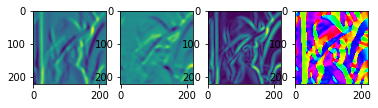

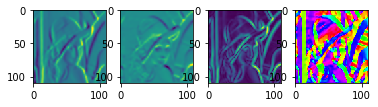

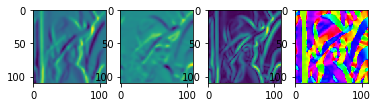

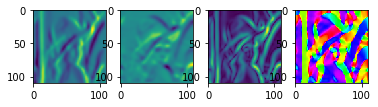

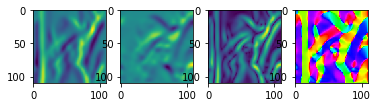

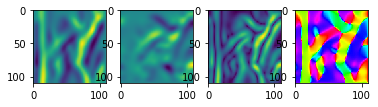

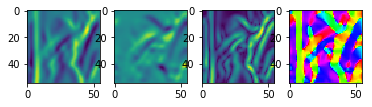

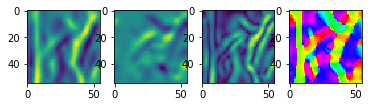

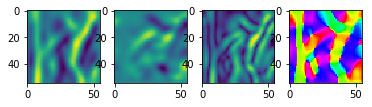

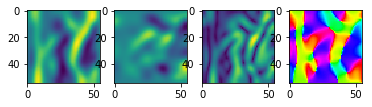

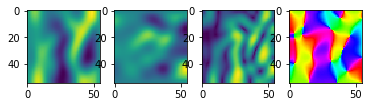

In [157]:
for octave in gradients:
    for scale, gradients_in_octave in octave.items():
        plt.figure()
        plt.subplot(1, 4, 1)
        plt.imshow(gradients_in_octave['grads'][0])
        plt.subplot(1, 4, 2)
        plt.imshow(gradients_in_octave['grads'][1])
        plt.subplot(1, 4, 3)
        plt.imshow(gradients_in_octave['magnitudes'])
        plt.subplot(1, 4, 4)
        plt.imshow(gradients_in_octave['orientations'], cmap='hsv')

In [158]:
def gaussian_window(sigma, size):
    assert size % 2 == 0
    x, y = np.meshgrid(np.arange(-int(size / 2), int(size / 2)), 
                       np.arange(-int(size / 2), int(size / 2)))
    w = np.exp(-(np.power(x, 2) + np.power(y, 2)) / (2.0 * np.power(sigma, 2)))
    return w / np.sum(w)


def normalize_magnitudes(magnitudes, row, col, sigma, size):
    gw = gaussian_window(sigma, size)    
    return magnitudes[row - size // 2:row + size // 2, col - size // 2:col + size // 2] * gw
    

def calc_orientation_hist(magnitudes, orientations, num_bins):
    magnitudes = magnitudes.flatten()
    orientations = orientations.flatten()

    bins = np.zeros((num_bins, ))
    for i , o in enumerate(orientations):
        bins[int(o / (360 / len(bins)))] += magnitudes[i]
        
    return bins


def calc_keypoint_orientations(magnitudes, orientations):
    hist = calc_orientation_hist(magnitudes, orientations, 36)
    return np.where(hist >= np.max(hist) * 0.8)[0] * 10

In [159]:
def create_descriptors(scale_space, gradients, local_extrema, size):
    def should_be_ignored(row, col, size):
        return point[0] - size // 2 < 0 or point[0] + size // 2 > gradients[o][scale]['magnitudes'].shape[0] \
            or point[1] - size // 2 < 0 or point[1] + size // 2 > gradients[o][scale]['magnitudes'].shape[1]
    
    local_extrema = deepcopy(local_extrema)
    descriptors = []
    for o in range(len(local_extrema)):
        descriptors_in_octave = {}
        for scale, points in local_extrema[o].items():
            for point in points:
                if should_be_ignored(point[0], point[1], size):
                    continue
                    
                magnitudes = normalize_magnitudes(gradients[o][scale]['magnitudes'], point[0], point[1], size / 2., size)
                orientations = gradients[o][scale]['orientations'][point[0] - size // 2:point[0] + size // 2, point[1] - size // 2:point[1] + size // 2]
                
                keypoint_orientations = calc_keypoint_orientations(magnitudes, orientations)
                
                keypoint_descriptors = []
                for keypoint_orientation in keypoint_orientations:
                    normalized_orientations = orientations - keypoint_orientation
                    normalized_orientations[normalized_orientations < 0.] += 360.0
                    descriptor = []
                    descriptor.extend(calc_orientation_hist(magnitudes[0:size//2, 0:size//2], orientations[0:size//2, 0:size//2], 8))
                    descriptor.extend(calc_orientation_hist(magnitudes[size//2:size, 0:size//2], orientations[size//2:size, 0:size//2], 8))
                    descriptor.extend(calc_orientation_hist(magnitudes[size//2:size, size//2:size], orientations[size//2:size, size//2:size], 8))
                    descriptor.extend(calc_orientation_hist(magnitudes[0:size//2, size//2:size], orientations[0:size//2, size//2:size], 8))
                    if scale not in descriptors_in_octave:
                        descriptors_in_octave[scale] = []
                    descriptors_in_octave[scale].append({'descriptor': descriptor, 'point': point, 'orientation': keypoint_orientation})
        descriptors.append(descriptors_in_octave)
    return descriptors

In [176]:
descriptors = create_descriptors(scale_space, gradients, local_extrema, 16)

In [263]:
def draw_descriptors(space, descriptors, figsize=(5, 5), dpi=240):
    rows = len(space)
    cols = len(space[0])
    fig, axes = plt.subplots(rows, cols, figsize=figsize, dpi=dpi)
    for i, (o, scale, image) in enumerate(iter_over_space(space)):
        axes[o, i % cols].imshow(image, cmap='gray')
        axes[o, i % cols].axis('off')

        try:
            for descriptor in descriptors[o][scale]:
                point = descriptor['point']
                axes[o, i % cols].add_patch(Circle(point, 4, color='y'))
                axes[o, i % cols].plot((point[0], point[0] + 5 * np.sin(descriptor['orientation'] * np.pi / 180.)), 
                                       (point[1], point[1] + 5 * np.cos(descriptor['orientation'] * np.pi / 180.)), 
                                       'k-', lw=1, color='r')
        except KeyError:
            pass

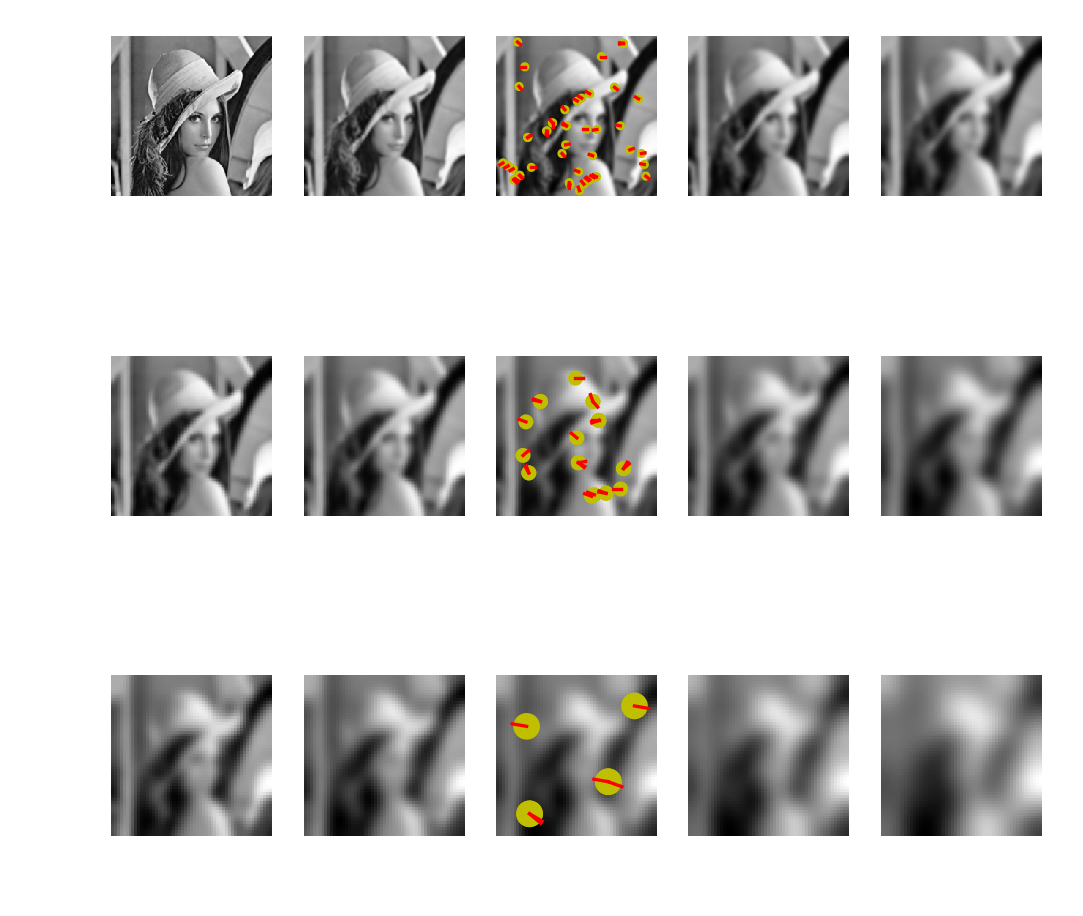

In [264]:
draw_descriptors(scale_space, descriptors)